In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [9]:
from pathlib import Path

def find_project_root():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        if (p / "data").is_dir() and (p / "src").is_dir():
            return p
    # fallback al tuo percorso noto su Windows
    return Path(r"C:\Users\MARTINADICORATO\Diabete_New\Diabete")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
CSV_PATH = DATA_DIR / "prod_interactions_v1.csv"

# Se non esiste, tenta una ricerca rapida
if not CSV_PATH.exists():
    try:
        CSV_PATH = next(PROJECT_ROOT.rglob("prod_interactions_v1.csv"))
    except StopIteration:
        raise FileNotFoundError(f"Non trovo diabete_data.csv sotto {PROJECT_ROOT}")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV:", CSV_PATH)

PROJECT_ROOT: C:\Users\MARTINADICORATO
CSV: C:\Users\MARTINADICORATO\Diabete_New\Diabete\data\prod_interactions_v1.csv


In [10]:
df = pd.read_csv(CSV_PATH)
df.head()

,timestamp,session_id,event_type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,predicted_class,probability,comune,ospedale,telefono,indirizzo,prenotazioni,note
0,2025-08-24T22:03:34,2b9f30fb-340a-4d21-8d5b-9e879c86b6bb,prediction,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-24T22:04:06,2b9f30fb-340a-4d21-8d5b-9e879c86b6bb,contact_view,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,Abbiategrasso,Policlinico di Milano (Ca’ Granda),+39 02 5503.1 (H24),"Via Francesco Sforza 28, Milano",Numero Verde Regionale: 800 638 638 (fisso) / ...,IRCCS; centro; include Clinica Mangiagalli
2,2025-08-24T22:06:34,2b9f30fb-340a-4d21-8d5b-9e879c86b6bb,contact_view,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,Abbiategrasso,Policlinico di Milano (Ca’ Granda),+39 02 5503.1 (H24),"Via Francesco Sforza 28, Milano",Numero Verde Regionale: 800 638 638 (fisso) / ...,IRCCS; centro; include Clinica Mangiagalli
3,2025-08-24T23:54:39,9655f3b4-bbad-4869-91b8-ba3254a733d5,prediction,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-08-24T23:55:44,9655f3b4-bbad-4869-91b8-ba3254a733d5,contact_view,0,0,0,24.2,0,0,0,0,0,0,0,0,0,3,2,2,0,0,40,4,4,0,0.9316,Arconate,Sacco (ASST Fatebenefratelli Sacco),+39 02 3904.1 (centralino),"Via Giovanni Battista Grassi 74, Milano",Numero Verde Regionale: 800 638 638 (fisso) / ...,Nord-ovest Milano


In [12]:
df.shape

(9, 32)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

print("Righe:", len(df))
print("Colonne:", df.columns.tolist())

Righe: 9
Colonne: ['timestamp', 'session_id', 'event_type', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'predicted_class', 'probability', 'comune', 'ospedale', 'telefono', 'indirizzo', 'prenotazioni', 'note']


In [19]:
# Mapping leggibile per il sesso
sex_map = {0: "Donna", 1: "Uomo"}
df["Sex_lbl"] = df["Sex"].map(sex_map)

In [20]:
# Binning età
def bin_age(x):
    if pd.isna(x): return None
    x = int(x)
    if x < 25: return "0-24"
    elif x < 35: return "25-34"
    elif x < 45: return "35-44"
    elif x < 55: return "45-54"
    elif x < 65: return "55-64"
    else: return "65+"
df["Age_grp"] = df["Age"].apply(bin_age)

In [22]:
# Subset
df_pred = df[df["event_type"]=="prediction"]
df_contact = df[df["event_type"]=="contact_view"]

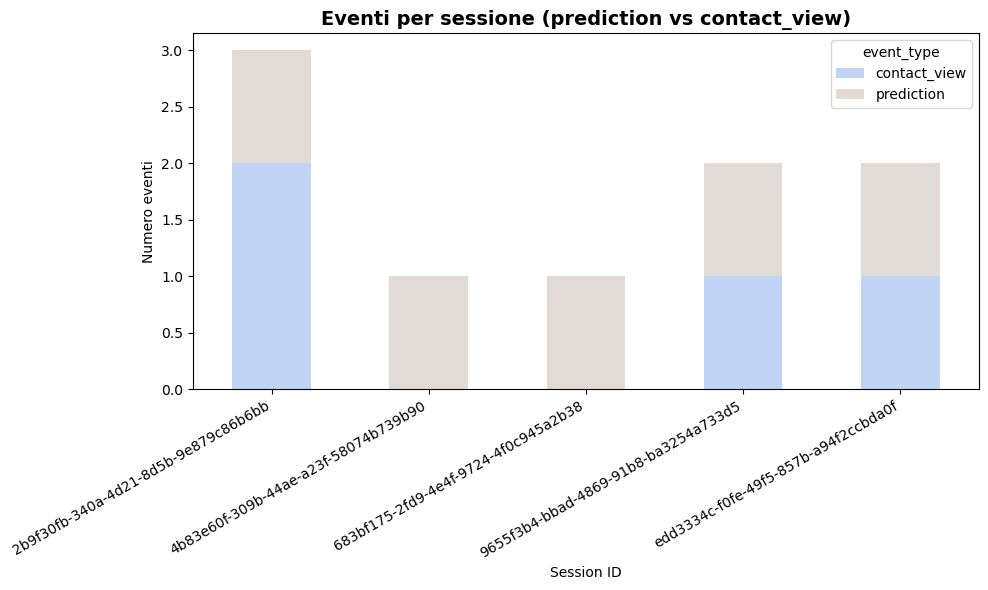

In [24]:
# Palette di riferimento
cmap = plt.cm.coolwarm
colors = [cmap(i) for i in np.linspace(0.4, 1, 6)]  # prende solo i toni più caldi (rosa-rossi)

# === 1) Eventi per sessione ===
counts = df.groupby(["session_id","event_type"]).size().unstack(fill_value=0)
ax = counts.plot(kind="bar", stacked=True, figsize=(10,6), color=colors[:2])
ax.set_title("Eventi per sessione (prediction vs contact_view)", fontsize=14, fontweight="bold")
ax.set_xlabel("Session ID")
ax.set_ylabel("Numero eventi")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

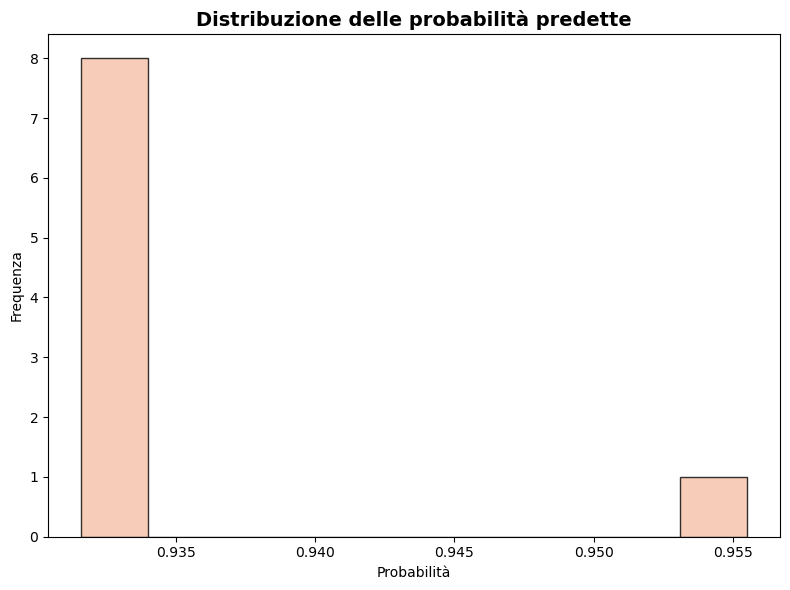

In [25]:
# === 2) Distribuzione probabilità ===
probs = df["probability"].dropna().astype(float)
plt.figure(figsize=(8,6))
plt.hist(probs, bins=10, edgecolor="black", alpha=0.8, color=colors[2])
plt.title("Distribuzione delle probabilità predette", fontsize=14, fontweight="bold")
plt.xlabel("Probabilità")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()

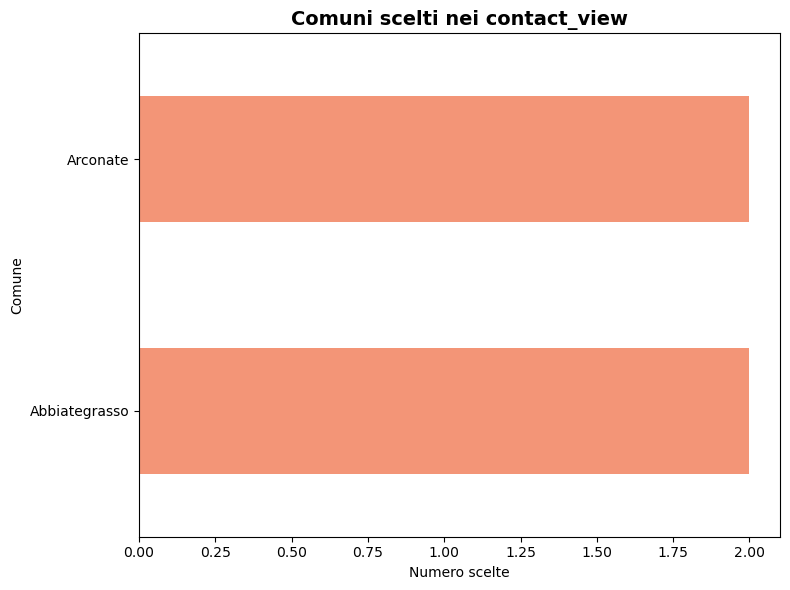

In [27]:
# === 3) Comuni scelti ===
if not df_contact.empty:
    vc = df_contact["comune"].dropna().value_counts()
    plt.figure(figsize=(8,6))
    vc.plot(kind="barh", color=colors[3])
    plt.title("Comuni scelti nei contact_view", fontsize=14, fontweight="bold")
    plt.xlabel("Numero scelte")
    plt.ylabel("Comune")
    plt.tight_layout()
    plt.show()

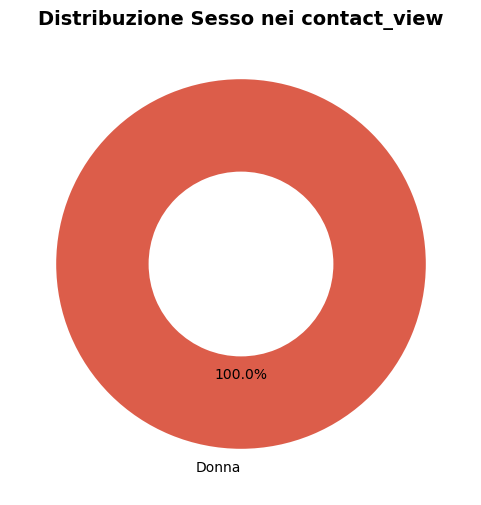

In [29]:
# === 4) Distribuzione sesso ===
if "Sex_lbl" in df_contact.columns and not df_contact["Sex_lbl"].dropna().empty:
    sex_counts = df_contact["Sex_lbl"].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(sex_counts, labels=sex_counts.index, autopct="%1.1f%%", startangle=90, 
            wedgeprops=dict(width=0.5), colors=[colors[4], colors[5]])
    plt.title("Distribuzione Sesso nei contact_view", fontsize=14, fontweight="bold")
    plt.show()

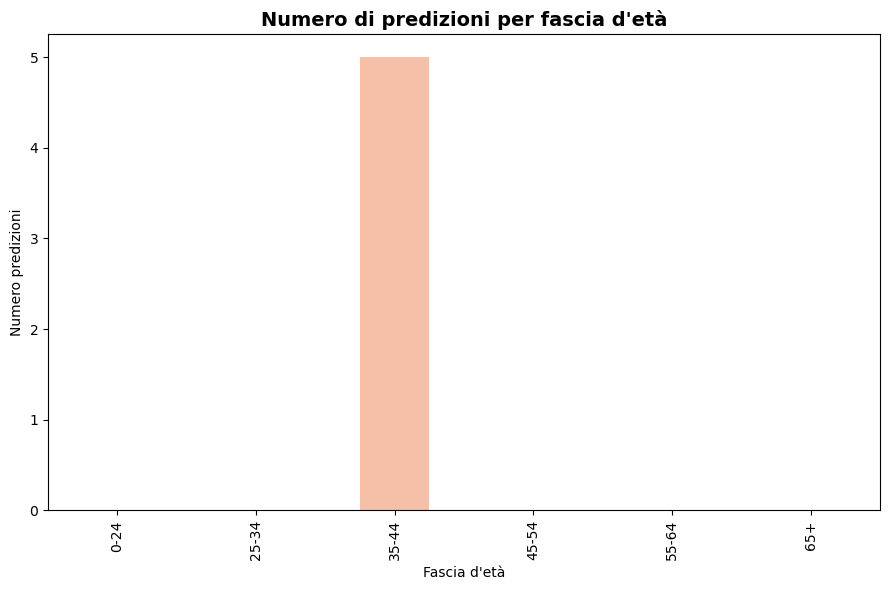

In [30]:
# === 5) Predizioni per fascia d’età ===
if "Age_grp" in df_pred.columns and not df_pred.empty:
    vc_age = df_pred["Age_grp"].value_counts().reindex(["0-24","25-34","35-44","45-54","55-64","65+"], fill_value=0)
    plt.figure(figsize=(9,6))
    vc_age.plot(kind="bar", color=colors)
    plt.title("Numero di predizioni per fascia d'età", fontsize=14, fontweight="bold")
    plt.xlabel("Fascia d'età")
    plt.ylabel("Numero predizioni")
    plt.tight_layout()
    plt.show()

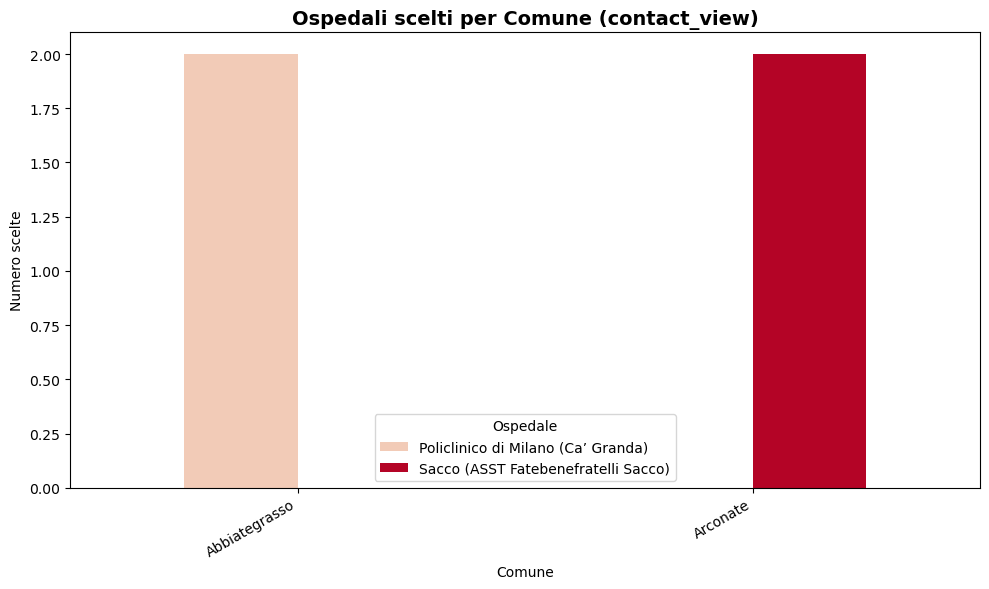

In [33]:
if not df_contact.empty and "ospedale" in df_contact.columns:
    pivot = df_contact.pivot_table(
        index="comune",
        columns="ospedale",
        values="session_id",
        aggfunc="count",
        fill_value=0
    )

    ax = pivot.plot(kind="bar", figsize=(10,6), color=plt.cm.coolwarm(np.linspace(0.6, 1, pivot.shape[1])))

    ax.set_title("Ospedali scelti per Comune (contact_view)", fontsize=14, fontweight="bold")
    ax.set_xlabel("Comune")
    ax.set_ylabel("Numero scelte")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Ospedale")
    plt.tight_layout()
    plt.show()
